# Data Exploration

This lab is *optional*. It demonstrates advanced Pandas usage and in-depth data analysis.

---

Learning objectives:

1. Learn useful patterns for exploring data before modeling
2. Gain an understanding of the dataset and identify any data issues.

The goal of this notebook is to explore our base tables before we began feature engineering and modeling. We will explore the price history of stock in the S&P 500.

* Price history : Price history of stocks
* S&P 500 : A list of all companies and symbols for companies in the S&P 500

For our analysis, let's limit price history since 2000. In general, the further back historical data is used the lower it's predictive power can be.

In [1]:
import os

PROJECT = !(gcloud config get-value core/project)
PROJECT = PROJECT[0]
BUCKET = PROJECT

os.environ["PROJECT"] = PROJECT
os.environ["BUCKET"] = BUCKET

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from google.cloud import bigquery
from IPython import get_ipython
from IPython.core.magic import register_cell_magic
from matplotlib import pyplot as plt

bq = bigquery.Client(project=PROJECT)

In [3]:
# Allow you to easily have Python variables in SQL query.
@register_cell_magic("with_globals")
def with_globals(line, cell):
    contents = cell.format(**globals())
    if "print" in line:
        print(contents)
    get_ipython().run_cell(contents)

## Preparing the dataset

Let's create the dataset in our project BiqQuery and import the stock data by running the following cells:

In [4]:
!bq mk stock_src

Dataset 'qwiklabs-asl-03-5d5c0ba6f6d6:stock_src' successfully created.


In [5]:
%%bash

TABLE=price_history
SCHEMA=symbol:STRING,Date:DATE,Open:FLOAT,Close:FLOAT
                
test -f $TABLE.csv || unzip ../stock_src/$TABLE.csv.zip
gsutil -m cp $TABLE.csv gs://$BUCKET/stock_src/$TABLE.csv
bq load --source_format=CSV --skip_leading_rows=1 \
    stock_src.$TABLE gs://$BUCKET/stock_src/$TABLE.csv  $SCHEMA

Archive:  ../stock_src/price_history.csv.zip
  inflating: price_history.csv       


Copying file://price_history.csv [Content-Type=text/csv]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

/ [1/1 files][185.8 MiB/185.8 MiB] 100% Done                                    
Operation completed over 1 objects/185.8 MiB.                                    
Waiting on bqjob_r498a537f3c1dc876_000001821cb13773_1 ... (34s) Current status: DONE   


In [6]:
%%bash

TABLE=eps
SCHEMA=date:DATE,company:STRING,symbol:STRING,surprise:STRING,reported_EPS:FLOAT,consensus_EPS:FLOAT
                
test -f $TABLE.csv || unzip ../stock_src/$TABLE.csv.zip
gsutil -m cp $TABLE.csv gs://$BUCKET/stock_src/$TABLE.csv
bq load --source_format=CSV --skip_leading_rows=1 \
    stock_src.$TABLE gs://$BUCKET/stock_src/$TABLE.csv  $SCHEMA

Archive:  ../stock_src/eps.csv.zip
  inflating: eps.csv                 


Copying file://eps.csv [Content-Type=text/csv]...
/ [1/1 files][  6.8 MiB/  6.8 MiB] 100% Done                                    
Operation completed over 1 objects/6.8 MiB.                                      
Waiting on bqjob_r5396fafc56a7a81b_000001821cb1d1fa_1 ... (2s) Current status: DONE   


In [7]:
%%bash

TABLE=snp500
SCHEMA=company:STRING,symbol:STRING,industry:STRING
                
test -f $TABLE.csv || unzip ../stock_src/$TABLE.csv.zip
gsutil -m cp $TABLE.csv gs://$BUCKET/stock_src/$TABLE.csv
bq load --source_format=CSV --skip_leading_rows=1 \
    stock_src.$TABLE gs://$BUCKET/stock_src/$TABLE.csv  $SCHEMA

Archive:  ../stock_src/snp500.csv.zip
  inflating: snp500.csv              


Copying file://snp500.csv [Content-Type=text/csv]...
/ [1/1 files][ 18.1 KiB/ 18.1 KiB] 100% Done                                    
Operation completed over 1 objects/18.1 KiB.                                     
Waiting on bqjob_r5428af5fe50d4995_000001821cb1ede5_1 ... (1s) Current status: DONE   


Let's look at the tables and columns we have for analysis. Please query the `INFORMATION_SCHEMA`.

**Learning objective 1.**

In [8]:
%%with_globals
%%bigquery --project {PROJECT}
SELECT table_name, column_name, data_type
FROM `stock_src.INFORMATION_SCHEMA.COLUMNS`
ORDER BY table_name, ordinal_position

Downloading: 100%|██████████| 13/13 [00:01<00:00,  8.75rows/s]


,table_name,column_name,data_type
0,eps,date,DATE
1,eps,company,STRING
2,eps,symbol,STRING
3,eps,surprise,STRING
4,eps,reported_EPS,FLOAT64
5,eps,consensus_EPS,FLOAT64
6,price_history,symbol,STRING
7,price_history,Date,DATE
8,price_history,Open,FLOAT64
9,price_history,Close,FLOAT64


## Price History

**TODO**: Visualize stock symbols from the dataset.

In [9]:
%%with_globals
%%bigquery --project {PROJECT}
SELECT *
FROM `stock_src.price_history`
LIMIT 10

Downloading: 100%|██████████| 10/10 [00:01<00:00,  7.59rows/s]


,symbol,Date,Open,Close
0,FINL,1992-12-22,21.75,21.50
1,FRX,1991-05-20,36.00,35.88
2,SUPX,1998-06-04,10.44,10.50
3,WPO,2012-11-15,335.00,340.00
4,IN,2002-03-21,7.05,7.71
5,KBH,2004-11-08,83.80,84.53
6,NPBC,1998-11-19,30.50,32.50
7,TDW,1998-05-14,38.19,38.37
8,GWW,1985-02-07,53.97,54.38
9,PMTC,1997-06-10,43.38,41.75


In [19]:
def query_stock(symbol):
    return bq.query(
        """
        SELECT *
        FROM `stock_src.price_history`
        WHERE symbol="{}"
        ORDER BY Date
    """.format(
            symbol
        )
    ).to_dataframe()

In [20]:
df_stock = query_stock("GOOG")

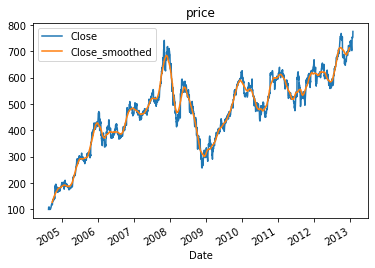

In [21]:
df_stock.Date = pd.to_datetime(df_stock.Date)
ax = df_stock.plot(x="Date", y="Close", title="price")

# Add smoothed plot.
df_stock["Close_smoothed"] = df_stock.Close.rolling(100, center=True).mean()
df_stock.plot(x="Date", y="Close_smoothed", ax=ax);

**TODO 2**: Compare individual stocks to the S&P 500.

In [22]:
SP500_SYMBOL = "gspc"
df_sp = query_stock(SP500_SYMBOL)

# TODO: visualize S&P 500 price
def plot_with_sp(symbol):
    df_stock = query_stock(symbol)
    df_stock.Date = pd.to_datetime(df_stock.Date)

    df_stock.Date = pd.to_datetime(df_stock.Date)

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()

    ax = df_sp.plot(
        x="Date", y="Close", label="S&P", color="green", ax=ax1, alpha=0.7
    )
    ax = df_stock.plot(
        x="Date",
        y="Close",
        label=symbol,
        title=symbol + " and S&P index",
        ax=ax2,
        alpha=0.7,
    )
    ax1.legend(loc=3)
    ax2.legend(loc=4)

    ax1.set_ylabel("S&P price")
    ax2.set_ylabel(symbol + " price")

    ax.set_xlim(pd.to_datetime("2004-08-05"), pd.to_datetime("2013-08-05"))

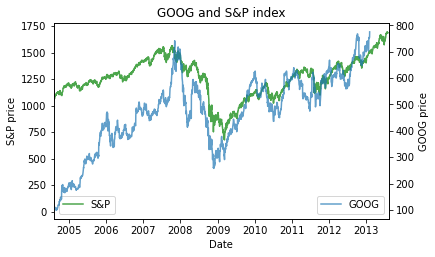

In [23]:
plot_with_sp("GOOG")

Let's see how the price of stocks change over time on a yearly basis. Using the `LAG` function we can compute the change in stock price year-over-year. 

Let's compute average close difference for each year. This line could, of course, be done in Pandas. Often times it's useful to use some combination of BigQuery and Pandas for exploration analysis. In general, it's most effective to let BigQuery do the heavy-duty processing and then use Pandas for smaller data and visualization.

**Learning objective 1, 2**

In [26]:
%%with_globals
%%bigquery df --project {PROJECT}
WITH 
with_year AS
    (
    SELECT symbol, 
    EXTRACT(YEAR FROM date) AS year,
    close
    FROM `stock_src.price_history`
    WHERE symbol in (SELECT symbol FROM `stock_src.snp500`)
    ),
year_aggregated AS
    (
    SELECT year, symbol, AVG(close) as avg_close
    FROM with_year
    WHERE year >= 2000
    GROUP BY year, symbol
    )
SELECT year, symbol, avg_close as close,
(LAG(avg_close, 1) OVER (PARTITION BY symbol ORDER BY year DESC) )
    AS next_yr_close
FROM year_aggregated
ORDER BY symbol, year

Downloading: 100%|██████████| 6598/6598 [00:01<00:00, 4097.81rows/s]


Compute the year-over-year percentage increase.

In [27]:
df.dropna(inplace=True)
df["percent_increase"] = (df.next_yr_close - df.close) / df.close

Let's visualize some yearly stock 

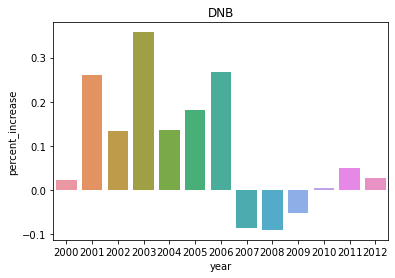

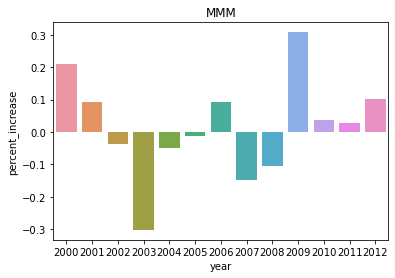

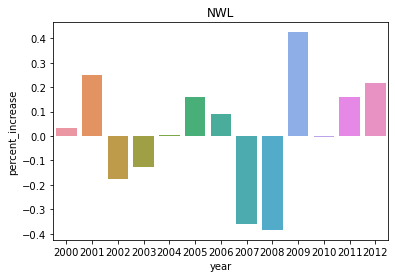

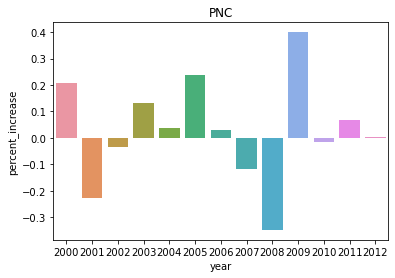

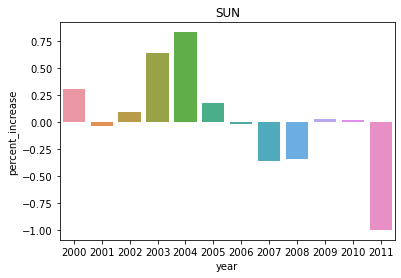

In [28]:
def get_random_stocks(n=5):
    random_stocks = df.symbol.sample(n=n, random_state=3)
    rand = df.merge(random_stocks)
    return rand[["year", "symbol", "percent_increase"]]


rand = get_random_stocks()
for symbol, _df in rand.groupby("symbol"):
    plt.figure()
    sns.barplot(x="year", y="percent_increase", data=_df)
    plt.title(symbol)

There have been some major fluctations in individual stocks. For example, there were major drops during the early 2000's for tech companies.

In [29]:
df.sort_values("percent_increase").head()

,year,symbol,close,next_yr_close,percent_increase
5590,2011,SUN,25.706718,0.033701,-0.998689
289,2000,AKAM,114.257817,9.826371,-0.913998
2648,2000,GLW,182.556230,20.907460,-0.885474
4685,2000,PCLN,37.684593,4.732903,-0.874407
6543,2000,YHOO,140.830675,18.375685,-0.869519


In [30]:
stock_symbol = "YHOO"

In [31]:
%%with_globals
%%bigquery df --project {PROJECT}
SELECT date, close
FROM `stock_src.price_history`
WHERE symbol='{stock_symbol}'
ORDER BY date

Downloading: 100%|██████████| 8462/8462 [00:01<00:00, 5994.02rows/s]


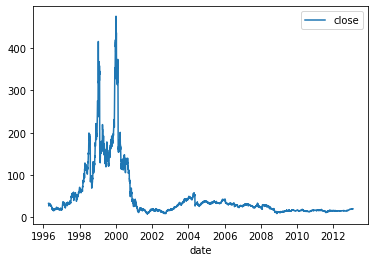

In [32]:
ax = df.plot(x="date", y="close")

**Stock splits** can also impact our data - causing a stock price to rapidly drop. In practice, we would need to clean all of our stock data to account for this. This would be a major effort! Fortunately, in the case of [IBM](https://www.fool.com/investing/2017/01/06/ibm-stock-split-will-2017-finally-be-the-year-shar.aspx), for example, all stock splits occurred before the year 2000.

**Learning objective 2**

**TODO**: Query the IBM stock history and to visualize how the stock splits affect our data. A stock split occurs when there is a sudden drop in price.

In [33]:
stock_symbol = "IBM"

In [34]:
%%with_globals
%%bigquery df --project {PROJECT}
SELECT date, close
FROM `stock_src.price_history`
WHERE symbol='{stock_symbol}'
ORDER BY date

Downloading: 100%|██████████| 25720/25720 [00:01<00:00, 18200.77rows/s]


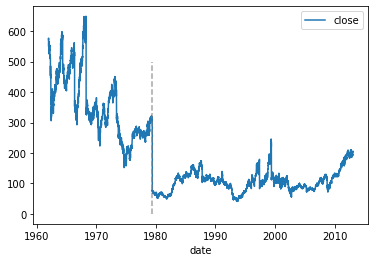

In [35]:
# TODO: can you visualize when the major stock splits occured?
IBM_STOCK_SPLIT_DATE = "1979-05-10"
ax = df.plot(x="date", y="close")
ax.vlines(
    pd.to_datetime(IBM_STOCK_SPLIT_DATE),
    0,
    500,
    linestyle="dashed",
    color="grey",
    alpha=0.7,
);

## S&P companies list

In [36]:
%%with_globals
%%bigquery df --project {PROJECT}
SELECT *
FROM `stock_src.snp500`

Downloading: 100%|██████████| 1000/1000 [00:01<00:00, 713.46rows/s]


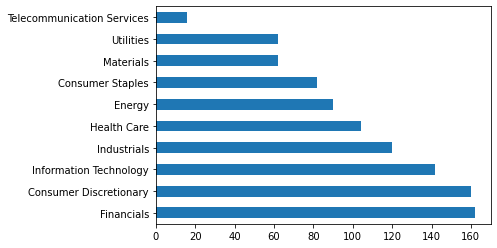

In [37]:
df.industry.value_counts().plot(kind="barh");

We can join the price histories table with the S&P 500 table to compare industries:

**Learning objective 1,2**

In [38]:
%%with_globals
%%bigquery df --project {PROJECT}
WITH sp_prices AS
    (
    SELECT a.*, b.industry
    FROM `stock_src.price_history` a 
        JOIN `stock_src.snp500` b
    USING (symbol)
    WHERE date >= "2000-01-01"
    )
SELECT Date, industry, AVG(close) as close
FROM sp_prices
GROUP BY Date, industry
ORDER BY industry, Date

Downloading: 100%|██████████| 33011/33011 [00:01<00:00, 25647.92rows/s]


In [39]:
df.head()

,Date,industry,close
0,2000-01-03,Consumer Discretionary,46.464000
1,2000-01-04,Consumer Discretionary,45.101538
2,2000-01-05,Consumer Discretionary,45.071077
3,2000-01-06,Consumer Discretionary,44.745077
4,2000-01-07,Consumer Discretionary,45.738308


Using pandas we can "unstack" our table so that each industry has it's own column. This will be useful for plotting.

In [40]:
# Pandas `unstack` to make each industry a column. Useful for plotting.
df_ind = df.set_index(["industry", "Date"]).unstack(0).dropna()
df_ind.columns = [c[1] for c in df_ind.columns]
df_ind.head()

,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Telecommunication Services,Utilities
Date,,,,,,,,,,
2000-01-03,46.464000,39.891515,27.628056,47.761667,42.437333,42.306786,104.093051,41.498148,43.745000,27.678621
2000-01-04,45.101538,39.041212,27.329167,46.081364,40.922889,41.256786,98.196949,40.727037,42.325000,27.781379
2000-01-05,45.071077,39.109091,27.551111,45.937273,41.751778,41.556071,96.666780,41.903333,43.031667,28.720690
2000-01-06,44.745077,39.567879,28.801111,46.985152,42.503111,42.248393,90.867119,42.911111,42.105000,28.782759
2000-01-07,45.738308,40.942121,29.426389,47.969091,45.214889,43.222679,96.180847,43.289630,42.458333,29.183793


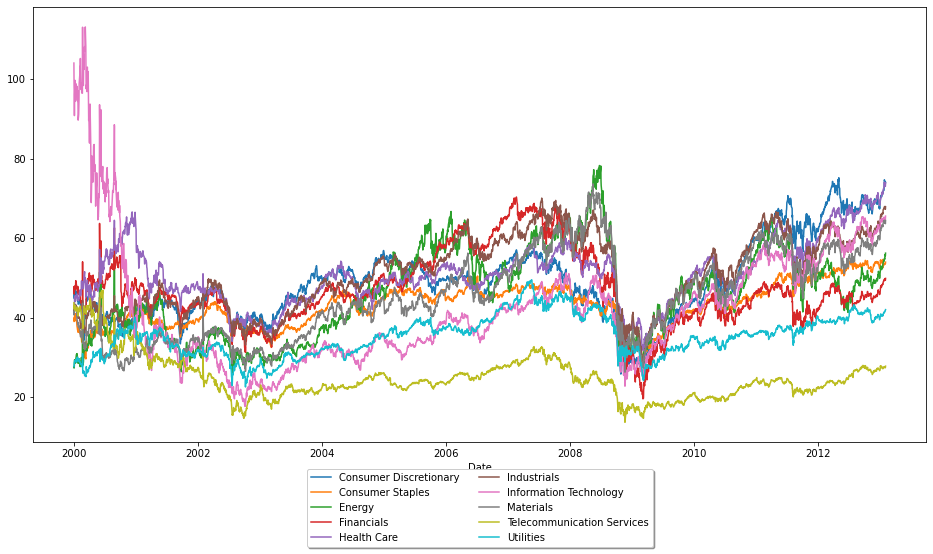

In [41]:
ax = df_ind.plot(figsize=(16, 8))
# Move legend down.
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)

Let's scale each industry using min/max scaling. This will put all of the stocks on the same scale. Currently it can be hard to see the changes in stocks over time across industries.

**Learning objective 1**

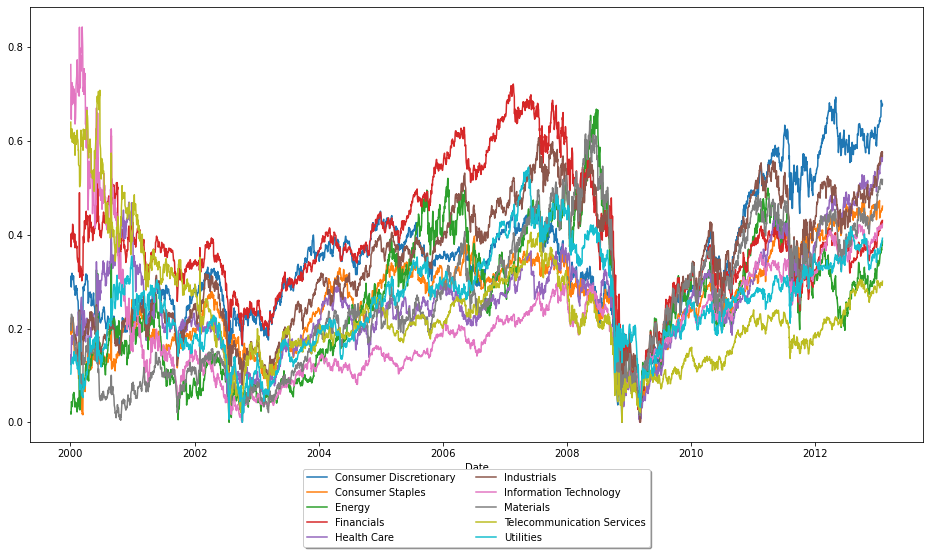

In [42]:
def min_max_scale(df):
    return (df - df.min()) / df.max()


scaled = min_max_scale(df_ind)
ax = scaled.plot(figsize=(16, 8))
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2);

We can also create a smoothed version of the plot above using a [rolling mean](https://en.wikipedia.org/wiki/Moving_average). This is a useful transformation to make when visualizing time-series data.

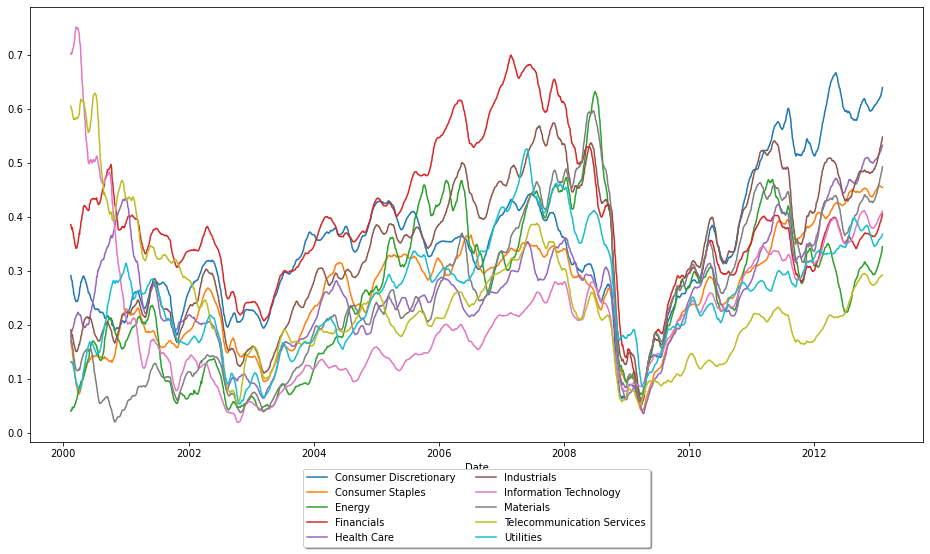

In [43]:
SMOOTHING_WINDOW = 30  # Days.
rolling = scaled.copy()
for col in scaled.columns:
    rolling[col] = scaled[col].rolling(SMOOTHING_WINDOW).mean()
ax = rolling.plot(figsize=(16, 8))
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2);

Information technology had a large crash during the early 2000s and again in 2008/2009; along with all other stocks. After 2008, some industries were a bit slower to recover than other industries.

BONUS: In the next lab, we will want to predict the price of the stock in the future. What are some features that we can use to predict future price? Try visualizing some of these features.

Copyright 2019 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License